In [1]:
from pypropagate import *
%matplotlib inline

In [2]:
settings = presets.create_paraxial_wave_equation_settings()

In [5]:
settings = presets.create_paraxial_wave_equation_settings()
s = settings.symbols

k = -1j/(2*settings.paraxial_equation.A)
wavelength = 2*pc.pi/k

g = settings.create_category('gaussian',info='Parameters of the gaussian beam')
g.create_symbol('w_0',info = 'Waist size')
g.create_symbol('z_r',pc.pi*g.w_0**2/wavelength,info='rayleigh range')
g.create_function('w_z',(s.r,s.z),g.w_0*(1+(s.z/g.z_r)**2)**0.5,info='beam width')
g.create_function('R_z',(s.r,s.z),s.z*(1+(g.z_r/s.z)**2),info='radius of curvature')
g.create_function('C_z',(s.r,s.z),pc.atan(s.z/g.z_r),info='gouy phase')
g.create_function('psi',(s.r,s.z),g.w_0/g.w_z * pc.exp(1j*g.C_z  - 1j*k*s.z - 1*s.r**2/g.w_z**2 - 1j*k*s.r**2 * pc.piecewise((1/(2*g.R_z) ,pc.unequal(s.z,0)),(0,True) ) ),info='general gaussian beam')

g.create_symbol('x_0',0,info = 'Focal point coordinate')
g.create_symbol('y_0',0,info = 'Focal point coordinate')
g.create_symbol('z_0',0,info = 'Focal point coordinate')

g.create_symbol('phi',0,info = 'incident angle')
g.create_function('Psi',(s.x,s.y,s.z),g.psi.subs((s.x,s.x*pc.cos(g.phi)-s.z*pc.sin(g.phi)),(s.z,s.x*pc.sin(g.phi)+s.z*pc.cos(g.phi))),'rotated gaussian beam')

g.create_function('u',(s.x,s.y,s.z),g.Psi.function(s.x-g.x_0,s.y-g.y_0,s.z-g.z_0) * pc.exp(1j*k*s.z),'paraxial gaussian beam')

settings.get(g.psi)

((z/k)**2*4/w_0_gaussian**4+1)**(-1/2)*exp((atan(-z/k/w_0_gaussian**2*2)+z*k)*i-(x**2+y**2)*(1/((z/k)**2*4/w_0_gaussian**4+1)/w_0_gaussian**2-k*i*piecewise(tuple(1/(z*((1/z*k)**2*w_0_gaussian**4/4+1))/2,0!=z),tuple(0,True))))

In [6]:
g.w_0 = 1*units.um
g.z_0 = 0 #s.sz/2
g.x_0 = 0 #s.xmax #0.5*units.cm

phi_parameter = pc.parameter('varphi',0.01*np.pi/180)
g.phi = phi_parameter

In [7]:
s.n = 1
s.u0 = g.u
s.u_boundary = g.u

In [8]:
beam_length = 100*units.mm
settings.wave_equation.set_energy(12*units.keV)

xsize = pc.Max(beam_length/units.m*pc.sin(g.phi),4*g.w_0/units.m) * units.m
s.zmin = -s.sz/2
settings.simulation_box.set((xsize,4*g.w_0,beam_length*pc.cos(g.phi)),(s.sx/s.sy * s.Ny,1500,1500))

In [9]:
phi_parameter.set_value(0.00*np.pi/180)

In [10]:
fieldan = expression_to_field(g.u.subs(s.y,s.fy),settings)
plot(fieldan,figsize=(13,4));

ValueError: unknown function: min


Simulation running. Step 1500/1500: 100% [███████████████████████] [76.5 s] [eta 0s +- 0s]


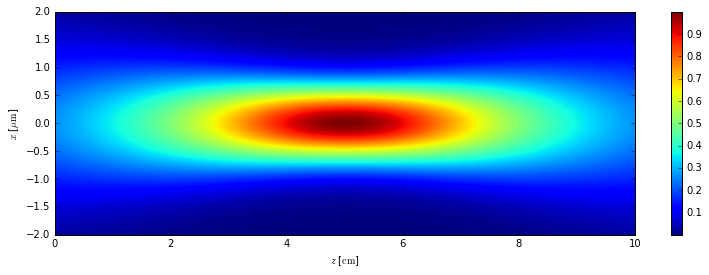

In [187]:
propagator = propagators.FiniteDifferencesPropagator2D(settings)
fieldfd = propagator.run_slice()[:,s.fy]
plot(fieldfd,figsize=(13,4));

In [188]:
abs(fieldfd - fieldan).max()

6.9731212778807942e-06

In [189]:
max_deviation = []
phi_values = []

In [190]:
## from pypropagate.progressbar import ProgressBar

i = 0

while len(max_deviation)==0 or max_deviation[-1] < 0.1:
    phi = i * 0.001
    if phi in phi_values:
        continue
    phi_parameter.set_value(phi*np.pi/180)
    fieldan = expression_to_field(g.u.subs(s.y,s.fy),settings)
    propagator = propagators.FiniteDifferencesPropagator2D(settings)
    fieldfd = propagator.run_slice(display_progress=True)[:,0]
    max_deviation.append(abs(fieldfd - fieldan).max())
    phi_values.append(phi)
    print (phi,max_deviation[-1])
    i += 1
  
np.savetxt('max_deviation.txt',list(zip(phi_values,max_deviation)))


Simulation running. Step 1500/1500: 100% [███████████████████████] [74.4 s] [eta 0s +- 0s]
(0.0, 6.9731212778807942e-06)

Simulation running. Step 1500/1500: 100% [███████████████████████] [78.6 s] [eta 0s +- 0s]
(0.001, 1.8191010626250225e-05)

Simulation running. Step 1500/1500: 100% [███████████████████████] [74.6 s] [eta 0s +- 0s]
(0.002, 6.1868893407941795e-05)

Simulation running. Step 1500/1500: 100% [███████████████████████] [98.4 s] [eta 0s +- 0s]
(0.003, 0.00020944756446037601)

Simulation running. Step 1500/1500: 100% [██████████████████████] [144.6 s] [eta 0s +- 0s]
(0.004, 0.00061820853371123143)

Simulation running. Step 1500/1500: 100% [██████████████████████] [194.1 s] [eta 0s +- 0s]
(0.005, 0.0015672443529003023)

Simulation running. Step 1500/1500: 100% [██████████████████████] [253.8 s] [eta 0s +- 0s]
(0.006, 0.00355168800422346)

Simulation running. Step 1500/1500: 100% [██████████████████████] [317.4 s] [eta 0s +- 0s]
(0.007, 0.007383711287660316)

Simulation runn

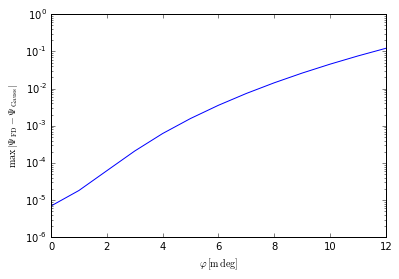

In [231]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(2,2))
plt.plot([v*1000 for v in phi_values],max_deviation)
plt.yscale('log')
plt.xlabel(r'$\varphi\,[\mathrm{m}\,\mathrm{deg} ]$')
plt.ylabel(r'$\mathrm{max}\, |\Psi_\mathrm{FD} - \Psi_\mathrm{Gauss} |$')

In [ ]:
phi_parameter.set_value(0.002*np.pi/180)
propagator = propagators.FiniteDifferencesPropagator2D(settings)
fieldfd = propagator.run_slice()[:,s.fy]
plot(fieldfd,figsize=(13,4));

In [ ]:
phi_parameter.set_value(0.004*np.pi/180)
propagator = propagators.FiniteDifferencesPropagator2D(settings)
fieldfd = propagator.run_slice()[:,s.fy]
plot(fieldfd,figsize=(13,4));

In [91]:
phi_parameter.set_value(0.01*np.pi/180)

<IPython.core.display.Javascript object>


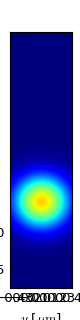

In [92]:
%matplotlib notebook

propagator = propagators.FiniteDifferencesPropagator2D(settings)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(1,4))
im = plot(propagator.get_field(),ax=plt.gca(),vmax=1)

try:
    for i in range(settings.get_as(s.Nz,int)):
        propagator.step()
        im.set_data(abs(propagator._get_field())**2)
        #im.autoscale()
        fig.canvas.draw()
except KeyboardInterrupt:
    %matplotlib inline
    pass

In [224]:
phi_parameter.set_value(0.00*np.pi/180)
propagator = propagators.FiniteDifferencesPropagator2D(settings)
fieldfd0 = propagator.run_slice()[:,s.fy]


Simulation running. Step 1500/1500: 100% [███████████████████████] [73.3 s] [eta 0s +- 0s]


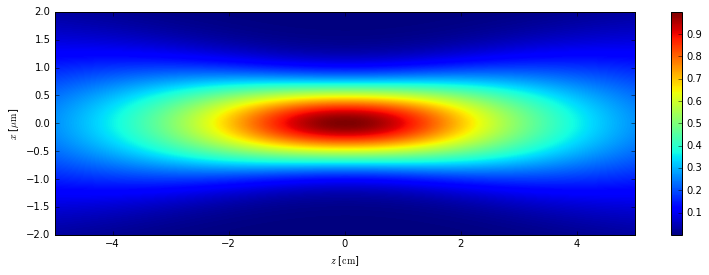

In [225]:
plot(fieldfd0,figsize=(13,4));

In [237]:
settings.simulation_box.set((xsize,4*g.w_0,1.5*beam_length*pc.cos(g.phi)),(s.sx/s.sy * s.Ny,1500,1.5*1500))

phi_parameter.set_value(0.004*np.pi/180)
propagator = propagators.FiniteDifferencesPropagator2D(settings)
fieldfd4 = propagator.run_slice()[:,s.fy]


Simulation running. Step 2250/2250: 100% [██████████████████████] [209.0 s] [eta 0s +- 0s]


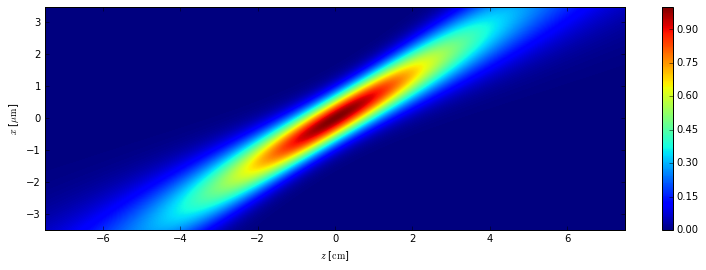

In [238]:
plot(fieldfd4,figsize=(13,4));

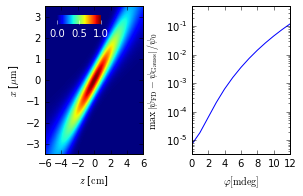

In [321]:
import matplotlib.pyplot as plt
fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(4,2.5))

im = plot(fieldfd4,ax=ax1,interpolation='none')
ax1.set_xlim(-6,6)

cbaxes = fig.add_axes([0.17, 0.9, 0.15, 0.05]) 
cbar = fig.colorbar(im,cax=cbaxes, orientation='horizontal')
cbaxes.tick_params(axis='x', colors='white')
for pos in ['top', 'bottom', 'right', 'left']:
    cbaxes.spines[pos].set_edgecolor('white')
cbar.outline.set_visible(False)
cbar.set_ticks([0.5*i for i in range(3)])

#phiaxes = fig.add_axes([0.61, 0.22, 0.25, 0.25])
phiaxes = ax2
phiaxes.plot([v*1000 for v in phi_values],max_deviation)
#phiaxes.tick_params(colors='white')
phiaxes.set_yscale('log')
#phiaxes.yaxis.set_ticks([10**(-2*i) for i in range(4)])
phiaxes.set_xlabel(r'$\varphi [\mathrm{m}\mathrm{deg}]$')
phiaxes.set_ylim(10**-5.5,0.5)
phiaxes.set_ylabel(r'$\mathrm{max}\, |\psi_\mathrm{FD} - \psi_\mathrm{Gauss} | \, / \psi_0$')
#phiaxes.xaxis.set_ticks([i*3 for i in range(5)])

plt.tight_layout(pad=0)

plt.savefig('gauss_fd.pdf')
plt.show()

#plt.xlabel(r'$\varphi\,[\mathrm{m}\,\mathrm{deg} ]$')
#plt.ylabel(r'$\mathrm{max}\, |\Psi_\mathrm{FD} - \Psi_\mathrm{Gauss} |$')

In [228]:
phi_parameter.set_value(0.008*np.pi/180)
propagator = propagators.FiniteDifferencesPropagator2D(settings)
fieldfd8 = propagator.run_slice()[:,s.fy]


Simulation running. Step 1500/1500: 100% [██████████████████████] [379.8 s] [eta 0s +- 0s]


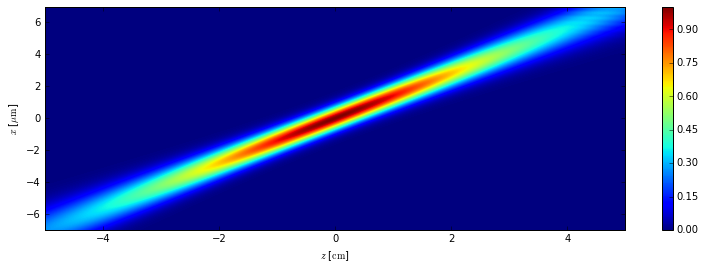

In [229]:
plot(fieldfd8,figsize=(13,4));

In [ ]:
propagators.FiniteDifferencesPropagator1D